In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
feature_0_bkg = np.random.randn(10000,1)
feature_0_sig = np.random.randn(10000,1)+3

feature_1_bkg = np.random.randn(10000,1)*5-20
feature_1_sig = np.random.randn(10000,1)*4-25

feature_2_bkg = np.random.rayleigh(1,10000).reshape(10000,1)
feature_2_sig = np.random.rayleigh(4,10000).reshape(10000,1)

feature_3_bkg = np.random.triangular(-3,0,8,10000).reshape(10000,1)
feature_3_sig = np.random.triangular(0,4,6,10000).reshape(10000,1)

labels_bkg = np.zeros((10000,1))
labels_sig = np.ones((10000,1))

In [26]:
data_bkg = np.concatenate((feature_0_bkg,
                           feature_1_bkg,
                           feature_2_bkg,
                           feature_3_bkg,
                           labels_bkg),
                          axis=1)

data_sig = np.concatenate((feature_0_sig,
                           feature_1_sig,
                           feature_2_sig,
                           feature_3_sig,
                           labels_sig),
                          axis=1)

In [27]:
data = np.concatenate((data_bkg,data_sig),axis=0)
np.random.shuffle(data)

In [28]:
features = data[:,:-1]
labels = data[:,-1]

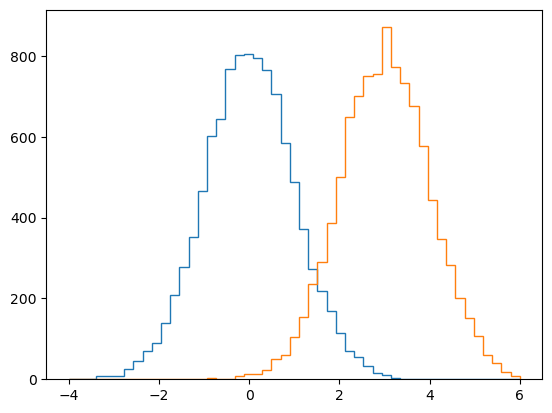

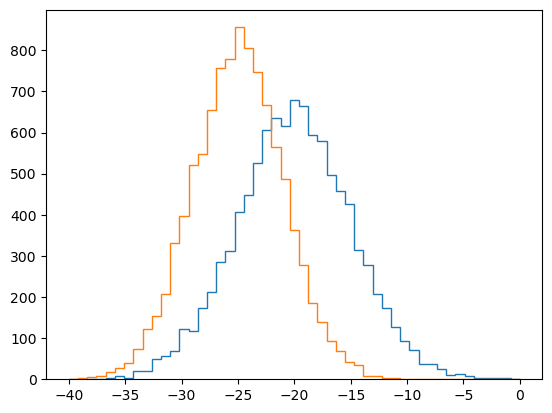

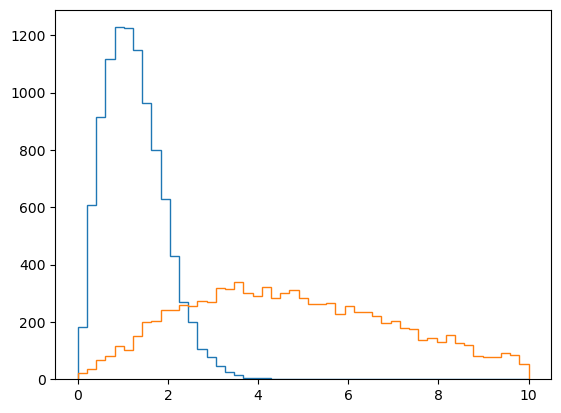

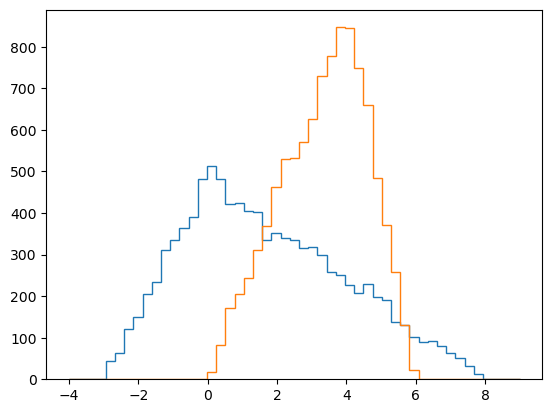

In [6]:
plt.hist(feature_0_bkg,histtype='step',bins=np.linspace(-4,6,50))
plt.hist(feature_0_sig,histtype='step',bins=np.linspace(-4,6,50))
plt.show()

plt.hist(feature_1_bkg,histtype='step',bins=np.linspace(-40,0,50))
plt.hist(feature_1_sig,histtype='step',bins=np.linspace(-40,0,50))
plt.show()

plt.hist(feature_2_bkg,histtype='step',bins=np.linspace(0,10,50))
plt.hist(feature_2_sig,histtype='step',bins=np.linspace(0,10,50))
plt.show()

plt.hist(feature_3_bkg,histtype='step',bins=np.linspace(-4,9,50))
plt.hist(feature_3_sig,histtype='step',bins=np.linspace(-4,9,50))
plt.show()

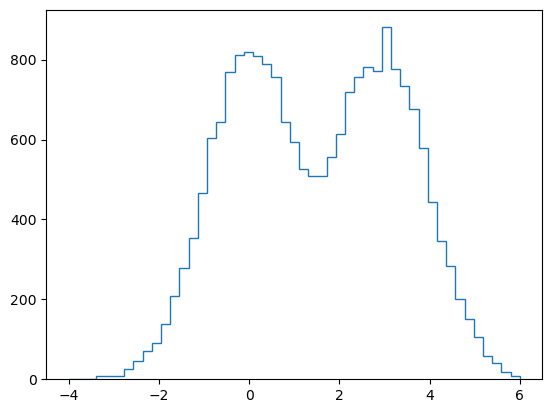

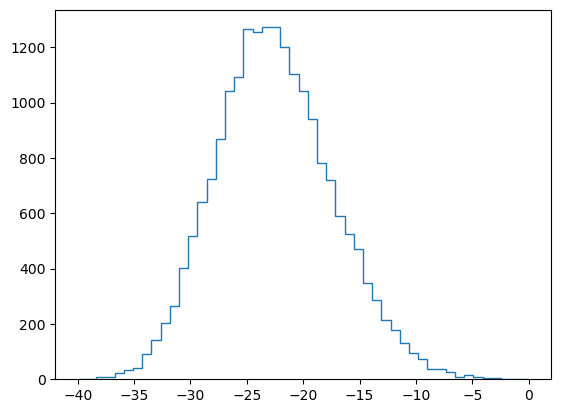

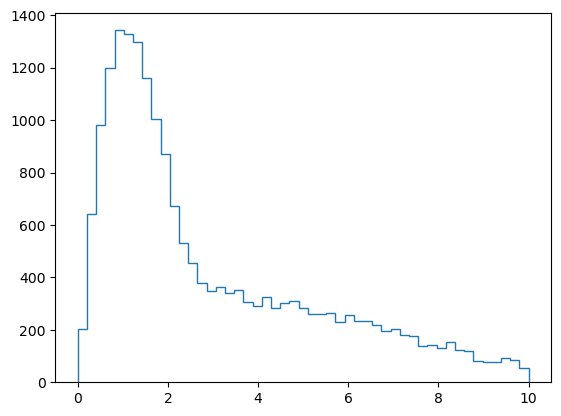

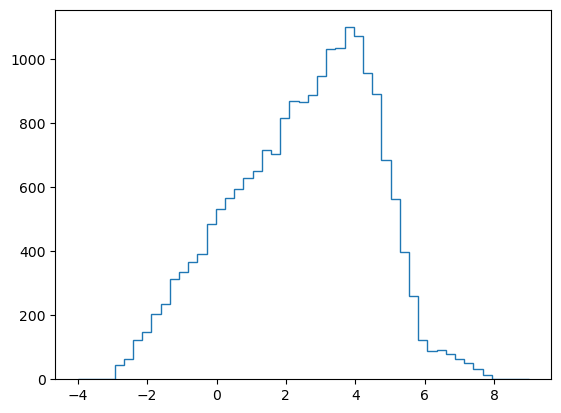

In [7]:
plt.hist(data[:,0],histtype='step',bins=np.linspace(-4,6,50))
plt.show()
plt.hist(data[:,1],histtype='step',bins=np.linspace(-40,0,50))
plt.show()
plt.hist(data[:,2],histtype='step',bins=np.linspace(0,10,50))
plt.show()
plt.hist(data[:,3],histtype='step',bins=np.linspace(-4,9,50))
plt.show()

In [8]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
import torch

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

In [13]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [14]:
# create dataset
data_torch = dataset(features,labels)

In [15]:
# shuffle
from torch.utils.data import random_split
from torch import Generator

train, validation = random_split(data_torch, 
                                 [int(0.8*20000), int(0.2*20000)], # fractions for train, validation
                                 generator=torch.Generator().manual_seed(42))

In [16]:
trainloader = DataLoader(train,batch_size=64,shuffle=True)
valloader = DataLoader(validation,batch_size=len(validation),shuffle=True)

In [17]:
#hyper parameters
learning_rate = 0.001
epochs = 200

# Model , Optimizer, Loss
model = Net(input_shape=features.shape[1])
model = torch.jit.script(model)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss() # mean squared error loss function

In [18]:
model

RecursiveScriptModule(
  original_name=Net
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

In [19]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    model.train()
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)
 
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
 
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    model.eval()
    for m,n in valloader:
        pred = model(m).reshape(-1).detach().numpy().round()
        acc = np.mean(pred==np.array(n))

    losses.append(loss.item())
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.17598660290241241	 accuracy : 0.92225
epoch 1	loss : 0.1582653522491455	 accuracy : 0.916
epoch 2	loss : 0.15010537207126617	 accuracy : 0.9135
epoch 3	loss : 0.11599210649728775	 accuracy : 0.9155
epoch 4	loss : 0.09957623481750488	 accuracy : 0.9135
epoch 5	loss : 0.1027260422706604	 accuracy : 0.91575
epoch 6	loss : 0.10022185742855072	 accuracy : 0.91675
epoch 7	loss : 0.09571551531553268	 accuracy : 0.91825
epoch 8	loss : 0.09786195307970047	 accuracy : 0.9215
epoch 9	loss : 0.10364824533462524	 accuracy : 0.92375
epoch 10	loss : 0.07118435949087143	 accuracy : 0.92475
epoch 11	loss : 0.09334667772054672	 accuracy : 0.92825
epoch 12	loss : 0.05856437236070633	 accuracy : 0.92925
epoch 13	loss : 0.07367702573537827	 accuracy : 0.93375
epoch 14	loss : 0.06071942299604416	 accuracy : 0.933
epoch 15	loss : 0.07202809303998947	 accuracy : 0.93425
epoch 16	loss : 0.08243467658758163	 accuracy : 0.934
epoch 17	loss : 0.061111945658922195	 accuracy : 0.937
epoch 18	loss :

Text(0, 0.5, 'loss')

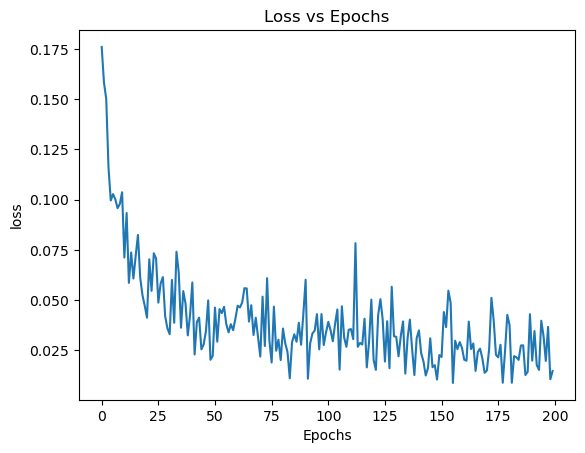

In [20]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

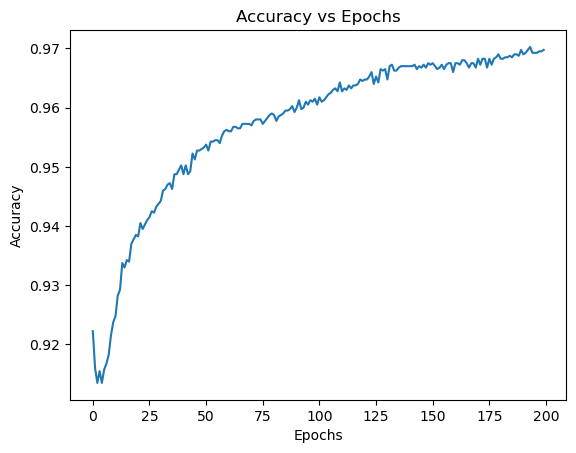

In [21]:
#plotting the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [22]:
model

RecursiveScriptModule(
  original_name=Net
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

In [23]:
torch.jit.save(model, "trained_testmodel.pt")

In [19]:
from torch.autograd import Variable
input_np = np.random.uniform(0, 1, (1, 4, 32, 32))
input_var = Variable(torch.FloatTensor(input_np))

In [21]:
from pytorch2keras.converter import pytorch_to_keras

# convert PyTorch model to Keras
kmodel = pytorch_to_keras(
    model_to_transfer,
    input_var,
    [(4, None, None,)],
    change_ordering=False,
    verbose=False,
    name_policy="keep",
    )

ModuleNotFoundError: No module named 'pytorch2keras'

In [17]:
for m,n in valloader:
    x = m

In [18]:
# save model to onnx
import torch.onnx

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "trained_testmodel.onnx",  # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [43]:
torch.save(model, "trained_testmodel.pt")